#Preparing the Data

In [44]:
import pandas as pd
import numpy as np
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall, AUC
import keras
from keras.models import Sequential, clone_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

import itertools
import matplotlib.pyplot as plt

SEED = 123

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#uploading local dataset (CSV File)
from google.colab import files
uploaded = files.upload()

In [46]:
#import io
#df2 = pd.read_csv(io.BytesIO(uploaded['Olympic Athletes Dataset.csv']))

#Extracting Raw Data

In [48]:
#From CSV file
csvFile = "Olympic Athletes Dataset.csv"
csvdata = pd.read_csv(csvFile)
csvdata.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [49]:
#Extracting the columns we want
csvraw = pd.DataFrame(csvdata[["Sex","Age","Height","Weight","Team","Sport","Medal"]])
csvraw.head()

,Sex,Age,Height,Weight,Team,Sport,Medal
0,M,24.0,180.0,80.0,China,Basketball,NaN
1,M,23.0,170.0,60.0,China,Judo,NaN
2,M,24.0,NaN,NaN,Denmark,Football,NaN
3,M,34.0,NaN,NaN,Denmark/Sweden,Tug-Of-War,Gold
4,F,21.0,185.0,82.0,Netherlands,Speed Skating,NaN


#Cleaning Up and Preparation of Data

In [50]:
#replcaing all types of medals: Bronze, Silver and Gold as 1
csvraw["Medal"] = csvraw["Medal"].map({'Bronze':"Y", 'Silver':"Y",'Gold':"Y"})

#replacing all NaN rows for medals as 0
csvraw["Medal"] = csvraw.Medal.fillna("N")

csvraw #to check

,Sex,Age,Height,Weight,Team,Sport,Medal
0,M,24.0,180.0,80.0,China,Basketball,N
1,M,23.0,170.0,60.0,China,Judo,N
2,M,24.0,NaN,NaN,Denmark,Football,N
3,M,34.0,NaN,NaN,Denmark/Sweden,Tug-Of-War,Y
4,F,21.0,185.0,82.0,Netherlands,Speed Skating,N
...,...,...,...,...,...,...,...
271111,M,29.0,179.0,89.0,Poland-1,Luge,N
271112,M,27.0,176.0,59.0,Poland,Ski Jumping,N
271113,M,27.0,176.0,59.0,Poland,Ski Jumping,N
271114,M,30.0,185.0,96.0,Poland,Bobsleigh,N


In [51]:
#check if there is a need to remove empty cells
csvraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Sex     271116 non-null  object 
 1   Age     261642 non-null  float64
 2   Height  210945 non-null  float64
 3   Weight  208241 non-null  float64
 4   Team    271116 non-null  object 
 5   Sport   271116 non-null  object 
 6   Medal   271116 non-null  object 
dtypes: float64(3), object(4)
memory usage: 14.5+ MB


In [52]:
#removing all the rows with empty cells
csvData=csvraw.dropna()
csvData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206165 entries, 0 to 271115
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Sex     206165 non-null  object 
 1   Age     206165 non-null  float64
 2   Height  206165 non-null  float64
 3   Weight  206165 non-null  float64
 4   Team    206165 non-null  object 
 5   Sport   206165 non-null  object 
 6   Medal   206165 non-null  object 
dtypes: float64(3), object(4)
memory usage: 12.6+ MB


In [53]:
csvData[["Medal"]] = csvData[["Medal"]].astype('category') #changing the object type
csvData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206165 entries, 0 to 271115
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   Sex     206165 non-null  object  
 1   Age     206165 non-null  float64 
 2   Height  206165 non-null  float64 
 3   Weight  206165 non-null  float64 
 4   Team    206165 non-null  object  
 5   Sport   206165 non-null  object  
 6   Medal   206165 non-null  category
dtypes: category(1), float64(3), object(3)
memory usage: 11.2+ MB


count     206165
unique         2
top            N
freq      175984
Name: Medal, dtype: object


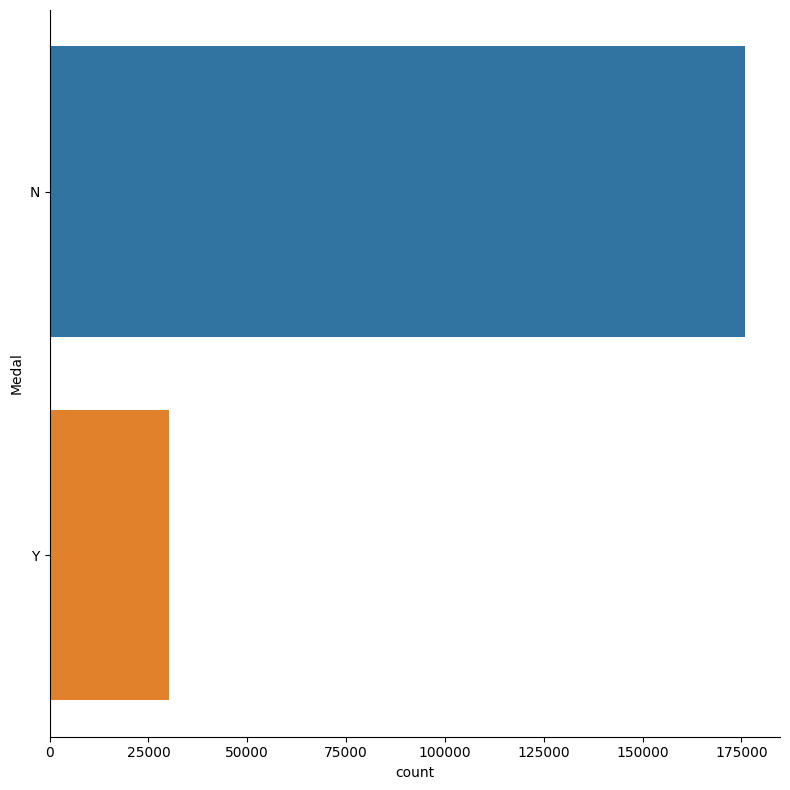

In [54]:
#evaluating the difference between the two medal classes
print (csvData['Medal'].describe())
sb.catplot(y = 'Medal', data = csvData, kind = "count", height = 8)

This could present errors later on during the machine learning phase as there is a wide discrepancy between the two classes. This would most likely cause a lot of error in predicting the Y class and will result in a very high FNR . To prevent this, we will try to even out the two classes.

##Evening out the N and Y Classes

In [55]:
# extracting only male that take part in swimming with medals
datamedals = csvData[(csvData.Medal == "Y")&(csvData.Sex == "M")&(csvData.Sport == "Swimming")]
datamedals

,Sex,Age,Height,Weight,Team,Sport,Medal
803,M,22.0,190.0,78.0,Soviet Union,Swimming,Y
804,M,22.0,190.0,78.0,Soviet Union,Swimming,Y
814,M,30.0,197.0,92.0,Australia,Swimming,Y
892,M,21.0,175.0,64.0,Great Britain,Swimming,Y
1843,M,19.0,198.0,100.0,United States,Swimming,Y
...,...,...,...,...,...,...,...
269783,M,29.0,208.0,93.0,Germany,Swimming,Y
270394,M,21.0,193.0,86.0,United States,Swimming,Y
270732,M,23.0,186.0,83.0,Netherlands,Swimming,Y
270773,M,20.0,193.0,82.0,Soviet Union,Swimming,Y


In [56]:
#choosing the team with the most number of medals won in swimming
n=1
datamedals.value_counts(["Team"])[:n].index.tolist()

[('United States',)]

In [57]:
#extract data from US, South Korea and China
cleanData = csvData[(csvData.Sex == "M")&((csvData.Team == "United States")
                    |(csvData.Team == "Singapore") |(csvData.Team == "South Korea")
                    |(csvData.Team == "China"))
                    &(csvData.Sport == "Swimming")]
cleanData = cleanData.reset_index() #reset indexes
cleanData = cleanData.drop(['index'], axis = 1)
cleanData

,Sex,Age,Height,Weight,Team,Sport,Medal
0,M,19.0,198.0,100.0,United States,Swimming,Y
1,M,23.0,198.0,100.0,United States,Swimming,Y
2,M,23.0,198.0,100.0,United States,Swimming,Y
3,M,23.0,198.0,100.0,United States,Swimming,Y
4,M,27.0,198.0,100.0,United States,Swimming,Y
...,...,...,...,...,...,...,...
1046,M,22.0,177.0,85.0,China,Swimming,N
1047,M,22.0,177.0,85.0,China,Swimming,N
1048,M,21.0,193.0,86.0,United States,Swimming,N
1049,M,21.0,193.0,86.0,United States,Swimming,Y


In [58]:
#validate if no. of Y and N class are similar
cleanData ['Medal'].value_counts()

N    527
Y    524
Name: Medal, dtype: int64

This is to develop a more robust classifier. Only data of athletes from the United States, South Korea and China were selected and compared since the United States has the most medals and both South Korea and China have similar BMI indexes to Singaporeans. This resulted in a more even class distribution which will be seen later.

#Machine Learning Method 2: Artificial Neural Network

There are a total of 1051 rows. The training and test set will carry 80% to 20% of the data respectively. Therefore, the training data will have 841 rows and the test data will have 210 rows.

In [59]:
#calculating the number of messages in each category
numbers = cleanData.groupby(["Medal"]).count()

numbers

,Sex,Age,Height,Weight,Team,Sport
Medal,,,,,,
N,527,527,527,527,527,527
Y,524,524,524,524,524,524


In [60]:
#using the majority of the data as our benchmark
#calculate by dividing the total counts in the majority class with the total counts of both classes
benchMark = 527/(527+524)

benchMark

0.5014272121788773

##Training the Data for AGE

In [61]:
cleandata_medal = pd.DataFrame(cleanData['Medal'])
cleandata_num = pd.DataFrame(cleanData[['Age','Weight','Height']])

In [62]:
testSize = 0.2
cleandata_age = pd.DataFrame(cleandata_num['Age'])
age_train, age_test, medal_train, medal_test = train_test_split(cleandata_age, cleandata_medal,
                                                                test_size = testSize,
                                                                random_state=SEED)

In [63]:
labelEncoder = LabelEncoder()
labelEncoder.fit(cleandata_medal)

y_train = labelEncoder.transform(medal_train)
y_test = labelEncoder.transform(medal_test)

In [64]:
weights = compute_class_weight('balanced', classes = np.unique(y_train),
                               y=np.ravel(y_train))
classWeights = dict(enumerate(weights))

classWeights

{0: 1.0, 1: 1.0}

According to DLWP, for a binary classification, it is recommended that we use `RMSProp` as our optimizer, `Binary_Crossentropy` as our loss function, `reLU` as our activation and `Sigmoid` as our last layer of activation.

###Optimizer
We will be using `Root Mean Squared Propagation (RMSProp)` since it will be able to accelerate the optimization process throughout the analysis. This is done by reducing the number of functions that are needed to result in a better final result.

###Loss Function
Since this is a binary classification problem and the output will be a probability, it is best to use `Binary_Crossentropy` loss since we are dealing with models that output probabilities.

###Activation
`ReLU` solves the vanishing gradient problem and stops the inactive neurons. Using the `Sigmoid` in the last layer output can represent the probability of binary classes which is best suited for our dataset.

In [65]:
INPUTAGE_DIMENSION = age_train.shape[1]

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

In [66]:
#initialising ANN
baselineAgeModel = tf.keras.models.Sequential()

#adding first hidden layer
baselineAgeModel.add(tf.keras.layers.Dense(64, activation="relu",
                                        input_shape=(INPUTAGE_DIMENSION,)))

#adding second hidden layer
baselineAgeModel.add(tf.keras.layers.Dense(32, activation="relu"))

#adding third hidden layer
baselineAgeModel.add(tf.keras.layers.Dense(16, activation="relu"))


#adding output later
baselineAgeModel.add(tf.keras.layers.Dense(1, activation="sigmoid"))

baselineAgeModel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                128       
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2753 (10.75 KB)
Trainable params: 2753 (10.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
learning_rate = 0.001

baselineAgeModel.compile(optimizer=RMSprop(learning_rate=learning_rate),
                      loss=LOSS_FUNC, metrics=METRICS)

In [68]:
EPOCHS = 100
batch_size=32

baselineInitialWeights = baselineAgeModel.get_weights()
baselineAgeModel.set_weights(baselineInitialWeights)

benchmarkAgeModel = baselineAgeModel.fit(age_train, y_train,
                                   class_weight=classWeights,
                                   batch_size=batch_size, epochs=EPOCHS,
                                   verbose=0)

In [69]:
benchmarkAgeScores = baselineAgeModel.evaluate(age_train, y_train, verbose=0)[1:]

print('Accuracy (AGE):  {:.2f} (Benchmark={:.2f})'.format(benchmarkAgeScores[0], benchMark))
print('Precision (AGE): {:.2f}'.format(benchmarkAgeScores[1]))
print('Recall (AGE) :   {:.2f}'.format(benchmarkAgeScores[2]))
print('AUC (AGE):       {:.2f}'.format(benchmarkAgeScores[3]))

Accuracy (AGE):  0.54 (Benchmark=0.50)
Precision (AGE): 0.77
Recall (AGE) :   0.11
AUC (AGE):       0.61


In [70]:
EPOCHS = 100
batch_size=32

baselineInitialWeights = baselineAgeModel.get_weights()
baselineAgeModel.set_weights(baselineInitialWeights)

benchmarkAgeModel = baselineAgeModel.fit(age_test, y_test,
                                   class_weight=classWeights,
                                   batch_size=batch_size, epochs=EPOCHS,
                                   verbose=0)

In [71]:
benchmarkAgeScores = baselineAgeModel.evaluate(age_test, y_test, verbose=0)[1:]

print('Accuracy (AGE):  {:.2f} (Benchmark={:.2f})'.format(benchmarkAgeScores[0], benchMark))
print('Precision (AGE): {:.2f}'.format(benchmarkAgeScores[1]))
print('Recall (AGE) :   {:.2f}'.format(benchmarkAgeScores[2]))
print('AUC (AGE):       {:.2f}'.format(benchmarkAgeScores[3]))

Accuracy (AGE):  0.55 (Benchmark=0.50)
Precision (AGE): 0.54
Recall (AGE) :   0.49
AUC (AGE):       0.58


##Training the Data for HEIGHT

In [72]:
testSize = 0.2
cleandata_height = pd.DataFrame(cleandata_num['Height'])
height_train, height_test, medal_train, medal_test = train_test_split(cleandata_height, cleandata_medal,
                                                                test_size = testSize,
                                                                random_state=SEED)

In [73]:
INPUTHEIGHT_DIMENSION = height_train.shape[1]

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

In [74]:
#initialising ANN
baselineHeightModel = tf.keras.models.Sequential()

#adding first hidden layer
baselineHeightModel.add(tf.keras.layers.Dense(64, activation="relu",
                                        input_shape=(INPUTHEIGHT_DIMENSION,)))

#adding second hidden layer
baselineHeightModel.add(tf.keras.layers.Dense(32, activation="relu"))

#adding third hidden layer
baselineHeightModel.add(tf.keras.layers.Dense(16, activation="relu"))

#adding output later
baselineHeightModel.add(tf.keras.layers.Dense(1, activation="sigmoid"))

baselineHeightModel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                128       
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2753 (10.75 KB)
Trainable params: 2753 (10.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
learning_rate = 0.001

baselineHeightModel.compile(optimizer=RMSprop(learning_rate=learning_rate),
                      loss=LOSS_FUNC, metrics=METRICS)

In [94]:
EPOCHS = 100
batch_size=32

baselineInitialWeights = baselineHeightModel.get_weights()
baselineHeightModel.set_weights(baselineInitialWeights)

benchmarkHeightModel = baselineHeightModel.fit(height_train, y_train,
                                   class_weight=classWeights,
                                   batch_size=batch_size, epochs=EPOCHS,
                                   verbose=0)

In [97]:
benchmarkHeightScores = baselineHeightModel.evaluate(height_train, y_train, verbose=0)[1:]

print('Accuracy (HEIGHT):  {:.2f} (Benchmark={:.2f})'.format(benchmarkHeightScores[0], benchMark))
print('Precision (HEIGHT): {:.2f}'.format(benchmarkHeightScores[1]))
print('Recall (HEIGHT) :   {:.2f}'.format(benchmarkHeightScores[2]))
print('AUC (HEIGHT):       {:.2f}'.format(benchmarkHeightScores[3]))

Accuracy (HEIGHT):  0.65 (Benchmark=0.50)
Precision (HEIGHT): 0.73
Recall (HEIGHT) :   0.47
AUC (HEIGHT):       0.69


In [96]:
EPOCHS = 100
batch_size=32

baselineInitialWeights = baselineHeightModel.get_weights()
baselineHeightModel.set_weights(baselineInitialWeights)

benchmarkHeightModel = baselineHeightModel.fit(height_test, y_test,
                                   class_weight=classWeights,
                                   batch_size=batch_size, epochs=EPOCHS,
                                   verbose=0)

In [92]:
benchmarkHeightScores = baselineHeightModel.evaluate(height_test, y_test, verbose=0)[1:]

print('Accuracy (HEIGHT):  {:.2f} (Benchmark={:.2f})'.format(benchmarkHeightScores[0], benchMark))
print('Precision (HEIGHT): {:.2f}'.format(benchmarkHeightScores[1]))
print('Recall (HEIGHT) :   {:.2f}'.format(benchmarkHeightScores[2]))
print('AUC (HEIGHT):       {:.2f}'.format(benchmarkHeightScores[3]))

Accuracy (HEIGHT):  0.62 (Benchmark=0.50)
Precision (HEIGHT): 0.77
Recall (HEIGHT) :   0.32
AUC (HEIGHT):       0.75


##Training the Data for WEIGHT

In [80]:
testSize = 0.2
cleandata_weight = pd.DataFrame(cleandata_num['Weight'])
weight_train, weight_test, medal_train, medal_test = train_test_split(cleandata_weight, cleandata_medal,
                                                                test_size = testSize,
                                                                random_state=SEED)

In [81]:
INPUTWEIGHT_DIMENSION = weight_train.shape[1]

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

In [82]:
#initialising ANN
baselineWeightModel = tf.keras.models.Sequential()

#adding first hidden layer
baselineWeightModel.add(tf.keras.layers.Dense(64, activation="relu",
                                        input_shape=(INPUTWEIGHT_DIMENSION,)))

#adding second hidden layer
baselineWeightModel.add(tf.keras.layers.Dense(32, activation="relu"))

#adding third hidden layer
baselineWeightModel.add(tf.keras.layers.Dense(16, activation="relu"))

#adding output later
baselineWeightModel.add(tf.keras.layers.Dense(1, activation="sigmoid"))

baselineWeightModel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                128       
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dense_22 (Dense)            (None, 16)                528       
                                                                 
 dense_23 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2753 (10.75 KB)
Trainable params: 2753 (10.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
learning_rate = 0.001

baselineWeightModel.compile(optimizer=RMSprop(learning_rate=learning_rate),
                      loss=LOSS_FUNC, metrics=METRICS)

In [84]:
EPOCHS = 100
batch_size=32

baselineInitialWeights = baselineWeightModel.get_weights()
baselineWeightModel.set_weights(baselineInitialWeights)

benchmarkWeightModel = baselineWeightModel.fit(weight_train, y_train,
                                   class_weight=classWeights,
                                   batch_size=batch_size, epochs=EPOCHS,
                                   verbose=0)

In [99]:
benchmarkWeightScores = baselineWeightModel.evaluate(weight_train, y_train, verbose=0)[1:]

print('Accuracy (WEIGHT):  {:.2f} (Benchmark={:.2f})'.format(benchmarkWeightScores[0], benchMark))
print('Precision (WEIGHT): {:.2f}'.format(benchmarkWeightScores[1]))
print('Recall (WEIGHT) :   {:.2f}'.format(benchmarkWeightScores[2]))
print('AUC (WEIGHT):       {:.2f}'.format(benchmarkWeightScores[3]))

Accuracy (WEIGHT):  0.64 (Benchmark=0.50)
Precision (WEIGHT): 0.69
Recall (WEIGHT) :   0.51
AUC (WEIGHT):       0.68


In [98]:
EPOCHS = 100
batch_size=32

baselineInitialWeights = baselineWeightModel.get_weights()
baselineWeightModel.set_weights(baselineInitialWeights)

benchmarkWeightModel = baselineWeightModel.fit(weight_test, y_test,
                                   class_weight=classWeights,
                                   batch_size=batch_size, epochs=EPOCHS,
                                   verbose=0)

In [87]:
benchmarkWeightScores = baselineWeightModel.evaluate(weight_test, y_test, verbose=0)[1:]

print('Accuracy (WEIGHT):  {:.2f} (Benchmark={:.2f})'.format(benchmarkWeightScores[0], benchMark))
print('Precision (WEIGHT): {:.2f}'.format(benchmarkWeightScores[1]))
print('Recall (WEIGHT) :   {:.2f}'.format(benchmarkWeightScores[2]))
print('AUC (WEIGHT):       {:.2f}'.format(benchmarkWeightScores[3]))

Accuracy (WEIGHT):  0.65 (Benchmark=0.50)
Precision (WEIGHT): 0.67
Recall (WEIGHT) :   0.56
AUC (WEIGHT):       0.69
